**Make sure to enable GPU runtime in colab**

GANs can be computationally expensive to train. The provided baseline configuration should train within a reasonable time on a free-tier Colab GPU. Be mindful of training time when running your experiments. The free-tier provides approx 2 Hrs of GPU time per account every few days in our experience. So you might have to spread your training session across multiple days so start early.

 We recommend saving generated image samples at regular intervals (e.g., every 10 epochs) to visualize the training progress and diagnose issues like mode collapse early. Also save the logs of the the training parameters for plotting.(You need not submit the logs)

The Goal of this homework is not to assess your coding capabilities and is more intended as an exploration of the concept of GANs. Consequently you are allowed to use Generative models to assist you in the coding process. Do reference the models you have used for portions of the code as comments within the code



## **Example Code 1**
Below you can find a very simple implementation of GANs using a standard MLP neural network. The goal is for you to see the various parts that make up the GAN network in a simple network. You will not be using this particular code for your homework and it is purely meant for your understanding. You can try running it also if you're interested

Using device: cuda
Starting training...


Epochs:   0%|          | 0/500 [00:00<?, ?it/s]

Training finished. Generating sample images...


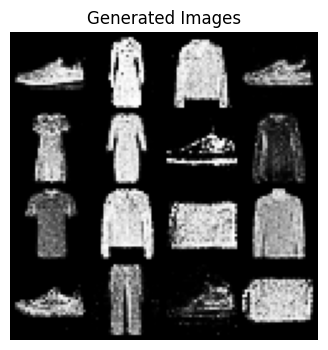

In [ ]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid
from tqdm.auto import tqdm
import matplotlib.pyplot as plt


# --- 1. Configuration and Setup ---


# Set the device for training (GPU if available, otherwise CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


# Set a seed for reproducibility
torch.manual_seed(42)
if device.type == 'cuda':
    torch.cuda.manual_seed_all(42)


# --- 2. Hyperparameters ---


latent_dim = 100
generator_hidden_layers = [256, 512, 1024]
discriminator_hidden_layers = [512, 256]
batch_size = 128
epochs = 100  # Each epoch takes around 14s in colab GPU. Adjust accordingly
learning_rate = 2e-4
adam_betas = (0.5, 0.999)  # Betas recommended for Adam optimizer in GANs
image_size = 28
image_channels = 1 # B&W Images
image_dim = image_size * image_size * image_channels


# --- 3. Data Loading ---


# Define transformations to apply to the images
# ToTensor() converts images to tensors in the range [0, 1]
# Normalize moves the range to [-1, 1] to match the Generator's Tanh output
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])


# Download and load the Fashion-MNIST dataset
train_dataset = datasets.FashionMNIST(
    root='./data',
    train=True,
    download=True,
    transform=transform
)


# Create a data loader to handle batching
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0,
    pin_memory=True
)


# --- 4. Model Definitions ---


class Generator(nn.Module):
    """
    The Generator network takes a random latent vector as input
    and generates an image.
    """
    def __init__(self, latent_dim, hidden_layers, output_dim):
        super().__init__()
        layers = []
        input_layer_size = latent_dim
        for hidden_size in hidden_layers:
            layers.extend([
                nn.Linear(input_layer_size, hidden_size),
                nn.LeakyReLU(0.2, inplace=True)
            ])
            input_layer_size = hidden_size

        # Final layer outputs a flattened image, followed by Tanh activation
        layers.extend([
            nn.Linear(input_layer_size, output_dim),
            nn.Tanh()
        ])

        self.net = nn.Sequential(*layers)

    def forward(self, z):
        # Generate flattened image data
        img_flat = self.net(z)
        # Reshape to image format [batch_size, channels, height, width]
        return img_flat.view(-1, image_channels, image_size, image_size)


class Discriminator(nn.Module):
    """
    The Discriminator network takes an image as input and outputs a
    single logit value indicating if the image is real or fake.
    """
    def __init__(self, input_dim, hidden_layers):
        super().__init__()
        layers = []
        input_layer_size = input_dim
        for hidden_size in hidden_layers:
            layers.extend([
                nn.Linear(input_layer_size, hidden_size),
                nn.LeakyReLU(0.2, inplace=True)
            ])
            input_layer_size = hidden_size

        # Final layer outputs a single logit (raw score)
        layers.append(nn.Linear(input_layer_size, 1))

        self.net = nn.Sequential(*layers)

    def forward(self, x):
        # Flatten the input image
        x_flat = x.view(x.size(0), -1)
        # Get the logit score
        return self.net(x_flat)


# --- 5. Initialization ---


# Initialize Generator and Discriminator and move them to the selected device
generator = Generator(latent_dim, generator_hidden_layers, image_dim).to(device)
discriminator = Discriminator(image_dim, discriminator_hidden_layers).to(device)


# Custom weight initialization (from DCGAN paper) for better stability
def initialize_weights(module):
    if isinstance(module, nn.Linear):
        nn.init.normal_(module.weight, 0.0, 0.02)
        if module.bias is not None:
            nn.init.zeros_(module.bias)


generator.apply(initialize_weights)
discriminator.apply(initialize_weights)


# Loss function and optimizers
loss_function = nn.BCEWithLogitsLoss()
optimizer_generator = optim.Adam(generator.parameters(), lr=learning_rate, betas=adam_betas)
optimizer_discriminator = optim.Adam(discriminator.parameters(), lr=learning_rate, betas=adam_betas)


# A fixed latent vector to visualize the generator's progress over time
fixed_latent_vector = torch.randn(16, latent_dim, device=device)


# --- 6. Training Loop ---


print("Starting training...")
for epoch in tqdm(range(1, epochs + 1), desc="Epochs"):
    generator.train()
    discriminator.train()

    epoch_discriminator_loss = 0.0
    epoch_generator_loss = 0.0

    # Loop over batches without a separate tqdm bar
    for real_images, _ in train_loader:

        real_images = real_images.to(device)
        current_batch_size = real_images.size(0)

        # Create labels for real and fake images
        real_labels = torch.ones(current_batch_size, 1, device=device)
        fake_labels = torch.zeros(current_batch_size, 1, device=device)

        # --- Train the Discriminator ---
        optimizer_discriminator.zero_grad()

        # 1. On real images
        discriminator_output_real = discriminator(real_images)
        discriminator_loss_real = loss_function(discriminator_output_real, real_labels)

        # 2. On fake images
        latent_vector = torch.randn(current_batch_size, latent_dim, device=device)
        with torch.no_grad():
            fake_images = generator(latent_vector)
        discriminator_output_fake = discriminator(fake_images.detach())
        discriminator_loss_fake = loss_function(discriminator_output_fake, fake_labels)

        # Combine losses and update
        discriminator_loss = discriminator_loss_real + discriminator_loss_fake
        discriminator_loss.backward()
        optimizer_discriminator.step()

        epoch_discriminator_loss += discriminator_loss.item()

        # --- Train the Generator ---
        optimizer_generator.zero_grad()

        # Generate new fake images and see what the discriminator thinks
        latent_vector = torch.randn(current_batch_size, latent_dim, device=device)
        fake_images = generator(latent_vector)
        discriminator_output = discriminator(fake_images)

        # Calculate loss by how well it fooled the discriminator (using real_labels)
        generator_loss = loss_function(discriminator_output, real_labels)

        # Update generator
        generator_loss.backward()
        optimizer_generator.step()

        epoch_generator_loss += generator_loss.item()

    # --- End of Epoch ---
    avg_discriminator_loss = epoch_discriminator_loss / len(train_loader)
    avg_generator_loss = epoch_generator_loss / len(train_loader)

    # Use tqdm.write to print loss without disturbing the progress bar
    #tqdm.write(f"Epoch {epoch}/{epochs} | D Loss: {avg_discriminator_loss:.4f} | G Loss: {avg_generator_loss:.4f}")


# --- 7. Visualization ---


print("Training finished. Generating sample images...")
# Set generator to evaluation mode and generate images from the fixed latent vector
generator.eval()
with torch.no_grad():
    sample_images = generator(fixed_latent_vector).cpu()


# Create a grid of the generated images
# normalize=True shifts the [-1, 1] output to [0, 1] for display
image_grid = make_grid(sample_images, nrow=4, normalize=True, value_range=(-1, 1))


# Plot the grid
plt.figure(figsize=(4, 4))
plt.axis('off')
plt.title("Generated Images")
plt.imshow(image_grid.permute(1, 2, 0))
plt.show()

## **Example code 2**
Below you can find a more standard implementation of GAN using a CNN network. You will need to use this particular architecture in all of your ablations and testing. The Second mobile-net model should also be based on a modified version of this code.

In [ ]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

# --- 1. Configuration and Setup ---

# Select device (GPU if available, otherwise CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
use_mixed_precision = device.type == "cuda"
print(f"Using device: {device}")

# Enable cuDNN autotuning for fixed input sizes (improves performance)
torch.backends.cudnn.benchmark = True

# Set seeds for reproducibility
torch.manual_seed(42)
if device.type == "cuda":
    torch.cuda.manual_seed_all(42)

# --- 2. Hyperparameters ---

latent_dimension = 100
generator_feature_maps = 16          # base width for Generator
discriminator_feature_maps = 16      # base width for Discriminator
image_size = 28
epochs = 80 # Each epoch takes around 15s in colab GPU. Adjust accordingly
batch_size = 256
learning_rate = 2e-4
adam_betas = (0.5, 0.999)            # Adam betas recommended for GANs

# --- 3. Data Loading ---

# Normalize Fashion-MNIST to [-1, 1] for compatibility with Tanh output
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

train_dataset = datasets.FashionMNIST(
    root="./data",
    train=True,
    download=True,
    transform=transform,
)

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0,
    pin_memory=True if device.type == "cuda" else False,
)

# --- 4. Model Definitions ---

# Weight initialization strategy (DCGAN-style)
def weights_init_dcgan(m):
    if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.Linear)):
        nn.init.normal_(m.weight, 0.0, 0.02)
        if getattr(m, "bias", None) is not None:
            nn.init.zeros_(m.bias)
    elif isinstance(m, (nn.BatchNorm1d, nn.BatchNorm2d)):
        nn.init.normal_(m.weight, 1.0, 0.02)
        nn.init.zeros_(m.bias)

class Generator(nn.Module):
    """
    Generator:
    Maps a latent vector to a 28x28 image
    using a combination of linear projection
    and transposed convolutions.
    """
    def __init__(self, latent_dim=100, feature_maps=32):
        super().__init__()
        self.latent_dim = latent_dim
        self.feature_maps = feature_maps

        self.project = nn.Sequential(
            nn.Linear(latent_dim, feature_maps * 4 * 7 * 7),
            nn.BatchNorm1d(feature_maps * 4 * 7 * 7),
            nn.ReLU(inplace=True),
        )
        self.upsample = nn.Sequential(
            nn.ConvTranspose2d(feature_maps * 4, feature_maps * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_maps * 2),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(feature_maps * 2, feature_maps, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_maps),
            nn.ReLU(inplace=True),
            nn.Conv2d(feature_maps, 1, 3, 1, 1, bias=False),
            nn.Tanh(),
        )

    def forward(self, noise):
        x = self.project(noise)
        x = x.view(noise.size(0), self.feature_maps * 4, 7, 7)
        return self.upsample(x)

class Discriminator(nn.Module):
    """
    Discriminator:
    Classifies an input image as real or fake
    using convolutional layers and a final linear logit.
    """
    def __init__(self, feature_maps=32):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, feature_maps, 4, 2, 1, bias=False),      # 28x28 -> 14x14
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(feature_maps, feature_maps * 2, 4, 2, 1, bias=False),  # 14x14 -> 7x7
            nn.BatchNorm2d(feature_maps * 2),
            nn.LeakyReLU(0.2, inplace=True),
        )
        self.classifier = nn.Linear(feature_maps * 2 * 7 * 7, 1)

    def forward(self, images):
        x = self.features(images)
        x = x.view(images.size(0), -1)
        return self.classifier(x)  # raw score (logit)

# Initialize models and apply weight init
generator = Generator(latent_dimension, generator_feature_maps).to(device)
discriminator = Discriminator(discriminator_feature_maps).to(device)
generator.apply(weights_init_dcgan)
discriminator.apply(weights_init_dcgan)

def count_parameters(model):
    """Counts the number of trainable parameters in a PyTorch model."""
    return sum(p.numel() for p in model.parameters() if p.requires_grad)




Using device: cpu


100%|██████████| 26.4M/26.4M [00:01<00:00, 18.2MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 271kB/s]
100%|██████████| 4.42M/4.42M [00:00<00:00, 5.06MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 22.5MB/s]


In [ ]:
class DepthwiseSeparableConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding, bias=False):
        super().__init__()
        self.depthwise = nn.Conv2d(
            in_channels,
            in_channels, # Key: out_channels = in_channels
            kernel_size=kernel_size,
            stride=stride,
            padding=padding,
            groups=in_channels, # Key: one filter per input channel
            bias=bias
        )
        self.pointwise = nn.Conv2d(
            in_channels,
            out_channels,
            kernel_size=1, # Key: 1x1 convolution
            bias=bias
        )

    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        return x

class ModifiedDiscriminator(nn.Module):
    def __init__(self, feature_maps=16): # Start with original feature_maps
        super().__init__()
        self.features = nn.Sequential(
            # Original: nn.Conv2d(1, feature_maps, 4, 2, 1, bias=False)
            DepthwiseSeparableConv2d(1, feature_maps, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            # Original: nn.Conv2d(feature_maps, feature_maps * 2, 4, 2, 1, bias=False)
            DepthwiseSeparableConv2d(feature_maps, feature_maps * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_maps * 2),
            nn.LeakyReLU(0.2, inplace=True),
        )
        self.classifier = nn.Linear(feature_maps * 2 * 7 * 7, 1)

    def forward(self, images):
        x = self.features(images)
        x = x.view(images.size(0), -1)
        return self.classifier(x)  # raw score (logit)

original_disc_params = count_parameters(discriminator)
compensated_disc_maps = 48
mod_disc_compensated = ModifiedDiscriminator(compensated_disc_maps).to(device)
mod_disc_compensated.apply(weights_init_dcgan)
mod_disc_comp_params = count_parameters(mod_disc_compensated)

print(f"Modified Discriminator Params: {mod_disc_comp_params:,} vs original discriminator params {original_disc_params} ") # 10337 vs 10081


import torch
import torch.nn as nn

class DepthwiseSeparableConvTranspose2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding, bias=False):
        super().__init__()
        # Pointwise convolution (1x1) to combine channels and prepare for upsampling
        self.pointwise = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=bias)
        # Depthwise transposed convolution for efficient spatial upsampling
        self.depthwise_transpose = nn.ConvTranspose2d(
            out_channels,
            out_channels,
            kernel_size=kernel_size,
            stride=stride,
            padding=padding,
            groups=out_channels, # Key: one filter per input channel
            bias=bias
        )

    def forward(self, x):
        x = self.pointwise(x)
        x = self.depthwise_transpose(x)
        return x

class ModifiedGenerator(nn.Module):
    def __init__(self, latent_dim=100, feature_maps=16):
        super().__init__()
        self.latent_dim = latent_dim
        self.feature_maps = feature_maps

        # Project the latent vector to the initial 7x7 resolution
        self.project = nn.Sequential(
            nn.Linear(latent_dimension, feature_maps * 4 * 7 * 7),
            nn.BatchNorm1d(feature_maps * 4 * 7 * 7),
            nn.ReLU(inplace=True),
        )

        # Upsample Block 1: 7x7 -> 14x14
        self.up_block1 = nn.Sequential(
            DepthwiseSeparableConvTranspose2d(feature_maps * 4, feature_maps * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_maps * 2),
            nn.ReLU(inplace=True),
        )

        # Upsample Block 2: 14x14 -> 28x28
        self.up_block2 = nn.Sequential(
            DepthwiseSeparableConvTranspose2d(feature_maps * 2, feature_maps, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_maps),
            nn.ReLU(inplace=True),
        )

        # Final output convolution
        self.output_conv = nn.Sequential(
            nn.Conv2d(feature_maps, 1, 3, 1, 1, bias=False),
            nn.Tanh(),
        )

    def forward(self, noise):
        x = self.project(noise)
        x = x.view(noise.size(0), self.feature_maps * 4, 7, 7)
        x = self.up_block1(x)
        x = self.up_block2(x)
        return self.output_conv(x)

original_gen_params = count_parameters(generator)
mod_gen = ModifiedGenerator(latent_dim = 100 , feature_maps = 16).to(device)
mod_gen.apply(weights_init_dcgan)
mod_gen_params = count_parameters(mod_gen)


print(f"Modified Generator Params: {mod_gen_params:,} vs original generator params {original_gen_params} ") # 346416 vs 364208





Modified Discriminator Params: 10,337 vs original discriminator params 10081 
Modified Generator Params: 326,576 vs original generator params 364208 


In [ ]:
discriminator = mod_disc_compensated
generator = mod_gen

/tmp/ipython-input-2303411298.py:9: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=use_mixed_precision)


Epochs:   0%|          | 0/80 [00:00<?, ?it/s]

/tmp/ipython-input-2303411298.py:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_mixed_precision):
/tmp/ipython-input-2303411298.py:59: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_mixed_precision):


Epoch 20/80 | Discriminator: 1.1012 | Generator: 1.0222


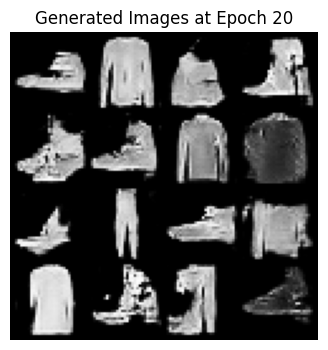

Epoch 40/80 | Discriminator: 1.1208 | Generator: 1.0260


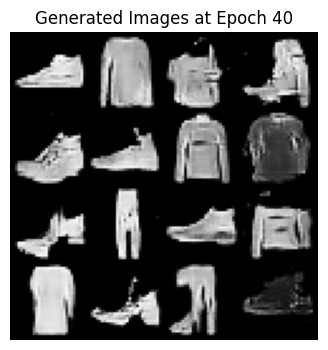

Epoch 60/80 | Discriminator: 1.1667 | Generator: 1.0366


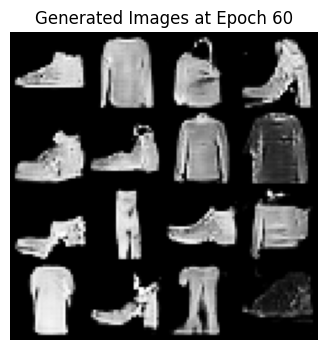

KeyboardInterrupt: 

In [ ]:
# --- 5. Loss and Optimizers ---

criterion = nn.BCEWithLogitsLoss()
optimizer_generator = optim.Adam(generator.parameters(), lr=learning_rate, betas=adam_betas)
optimizer_discriminator = optim.Adam(discriminator.parameters(), lr=learning_rate, betas=adam_betas)

# Enable automatic mixed precision (AMP) for speed on GPUs
from torch.cuda.amp import GradScaler, autocast
scaler = GradScaler(enabled=use_mixed_precision)

# Fixed noise vector to monitor generator progress
fixed_noise = torch.randn(16, latent_dimension, device=device)

# --- NEW: Loss Tracking Lists ---
G_losses = []
D_losses = []
epochs_list = []

# --- 6. Training Loop (MODIFIED) ---

for epoch in tqdm(range(1, epochs + 1), desc="Epochs"):
    generator.train()
    discriminator.train()

    running_discriminator_loss = 0.0
    running_generator_loss = 0.0
    steps = 0

    for real_images, _ in train_loader:
        real_images = real_images.to(device)
        batch_current = real_images.size(0)

        real_targets = torch.ones(batch_current, 1, device=device)
        fake_targets = torch.zeros(batch_current, 1, device=device)

        # --- Train Discriminator ---
        optimizer_discriminator.zero_grad(set_to_none=True)
        with autocast(enabled=use_mixed_precision):
            # On real images
            logits_real = discriminator(real_images)
            loss_real = criterion(logits_real, real_targets)

            # On fake images
            noise = torch.randn(batch_current, latent_dimension, device=device)
            with torch.no_grad():
                fake_images = generator(noise)
            logits_fake = discriminator(fake_images.detach())
            loss_fake = criterion(logits_fake, fake_targets)

            # Combine losses
            loss_discriminator = loss_real + loss_fake

        scaler.scale(loss_discriminator).backward()
        scaler.step(optimizer_discriminator)
        scaler.update()

        # --- Train Generator ---
        optimizer_generator.zero_grad(set_to_none=True)
        with autocast(enabled=use_mixed_precision):
            noise = torch.randn(batch_current, latent_dimension, device=device)
            generated_images = generator(noise)
            logits_generated = discriminator(generated_images)

            # Loss based on fooling the discriminator
            # The target for the generator is to make the discriminator think the images are REAL
            loss_generator = criterion(logits_generated, real_targets)

        scaler.scale(loss_generator).backward()
        scaler.step(optimizer_generator)
        scaler.update()

        running_discriminator_loss += loss_discriminator.item()
        running_generator_loss += loss_generator.item()
        steps += 1

    avg_d = running_discriminator_loss / max(1, steps)
    avg_g = running_generator_loss / max(1, steps)

    # --- Store Average Losses for Plotting ---
    D_losses.append(avg_d)
    G_losses.append(avg_g)
    epochs_list.append(epoch)

    if epoch % 10 == 0:
        print(f"Epoch {epoch}/{epochs} | Discriminator: {avg_d:.4f} | Generator: {avg_g:.4f}")

        # --- Visualization Checkpoint for Mode Collapse Check ---
        generator.eval()
        with torch.no_grad():
            preview = generator(fixed_noise).cpu()

        # Arrange generated images into a grid for display
        grid = make_grid(preview, nrow=4, normalize=True, value_range=(-1, 1))

        plt.figure(figsize=(4, 4))
        plt.axis("off")
        plt.title(f"Generated Images at Epoch {epoch}")
        plt.imshow(grid.permute(1, 2, 0))
        plt.show()

        # Set generator back to train mode
        generator.train()

# -----------------------------------------------
# --- 7. Final Visualization and Loss Curves ---
# -----------------------------------------------

# The final image grid will be shown by the checkpoint logic when epoch=100.

print("\n--- Plotting Training Curves ---")

plt.figure(figsize=(10, 5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(epochs_list, G_losses, label="Generator Loss (G)")
plt.plot(epochs_list, D_losses, label="Discriminator Loss (D)")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
#You can use this block of code to automatically close your runtime once you finish training so that you dont exhaust the free tier GPU
#Remember to auto download any files you need from the runtime before running this
from google.colab import runtime
runtime.unassign()